LSTM recurrent nueral network example.

This is the result of a tutorial modeling air pollution with readings hourly over a 5 year period. 




In [1]:
from datetime import datetime

import keras
from matplotlib import pyplot
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from sklearn.metrics import mean_squared_error

/Users/seggensperger/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

csv_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv'
date_columns = ['year', 'month', 'day', 'hour']
df = pd.read_csv(csv_url,  parse_dates = [date_columns], index_col=0, date_parser=parse)
df.drop('No', axis=1, inplace=True)

# manually specify column names
df.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']

df.index.name = 'date'

# mark all NA values with 0
df['pollution'].fillna(0, inplace=True)

# drop the first 24 hours
df = df[24:]

In [3]:
df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [4]:
len(df)

43800

In [5]:
df.describe()

,pollution,dew,temp,press,wnd_spd,snow,rain
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,94.013516,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023
std,92.252276,14.429326,12.193384,10.271411,50.022729,0.760582,1.416247
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,24.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,68.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,132.250000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


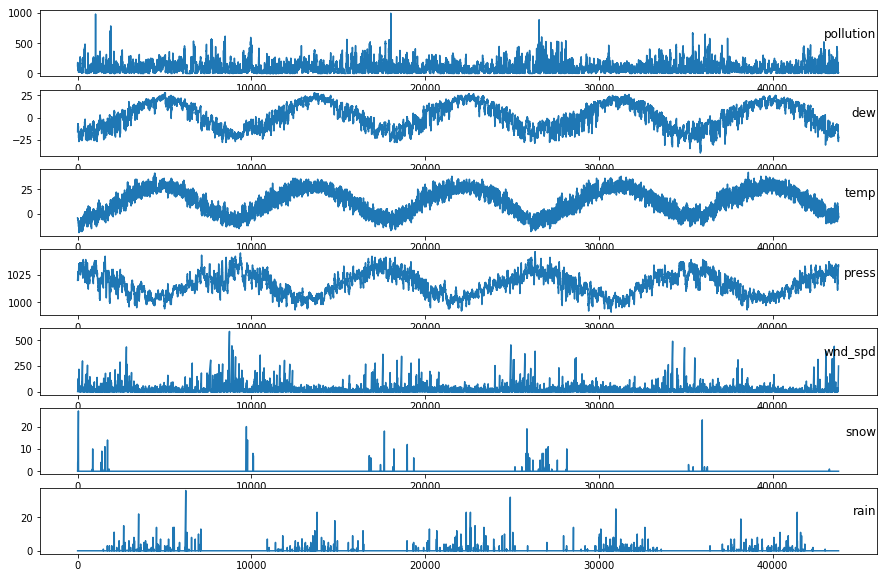

In [7]:
values = df.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column

pyplot.figure(figsize=(15,10))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(df.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [8]:
print(values[0])
values_copy = values.copy()
print(values_copy[0])

[129.0 -16 -4.0 1020.0 'SE' 1.79 0 0]
[129.0 -16 -4.0 1020.0 'SE' 1.79 0 0]


In [9]:
# copy of values for comparison


# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

# printing for comparison
print('original')
print(values_copy[0])
print('encoded')
print(values[0])


original
[129.0 -16 -4.0 1020.0 'SE' 1.79 0 0]
encoded
[ 129.    -16.     -4.   1020.      2.      1.79    0.      0.  ]


In [10]:
print(values[0])
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(scaled[0])

[ 129.    -16.     -4.   1020.      2.      1.79    0.      0.  ]
[0.12977867 0.35294122 0.24590163 0.5272732  0.6666667  0.00229001
 0.         0.        ]


In [39]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# frame as supervised learning using 
reframed = series_to_supervised(scaled, 1, 1)

reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0


In [40]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658


In [41]:
# split into train and test sets (with one year ast starting point)
values = reframed.values
n_train_hours = 365 * 24 *4
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]


In [42]:
print(len(train))
print(len(test))

35040
8759


In [43]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [44]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(35040, 1, 8) (35040,) (8759, 1, 8) (8759,)


In [45]:
# design network
model = keras.models.Sequential()
model.add(keras.layers.LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(keras.layers.Dense(1))
model.compile(loss='mae', optimizer='adam')

In [46]:
# fit network
history = model.fit(
    train_X, train_y, epochs=20, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 35040 samples, validate on 8759 samples
Epoch 1/20
 - 2s - loss: 0.0486 - val_loss: 0.0271
Epoch 2/20
 - 1s - loss: 0.0177 - val_loss: 0.0147
Epoch 3/20
 - 1s - loss: 0.0145 - val_loss: 0.0145
Epoch 4/20
 - 1s - loss: 0.0140 - val_loss: 0.0153
Epoch 5/20
 - 1s - loss: 0.0139 - val_loss: 0.0151
Epoch 6/20
 - 1s - loss: 0.0139 - val_loss: 0.0156
Epoch 7/20
 - 1s - loss: 0.0139 - val_loss: 0.0155
Epoch 8/20
 - 1s - loss: 0.0138 - val_loss: 0.0150
Epoch 9/20
 - 1s - loss: 0.0138 - val_loss: 0.0150
Epoch 10/20
 - 1s - loss: 0.0138 - val_loss: 0.0145
Epoch 11/20
 - 1s - loss: 0.0137 - val_loss: 0.0145
Epoch 12/20
 - 1s - loss: 0.0137 - val_loss: 0.0143
Epoch 13/20
 - 1s - loss: 0.0138 - val_loss: 0.0142
Epoch 14/20
 - 1s - loss: 0.0137 - val_loss: 0.0141
Epoch 15/20
 - 1s - loss: 0.0137 - val_loss: 0.0140
Epoch 16/20
 - 1s - loss: 0.0137 - val_loss: 0.0141
Epoch 17/20
 - 1s - loss: 0.0137 - val_loss: 0.0141
Epoch 18/20
 - 1s - loss: 0.0137 - val_loss: 0.0143
Epoch 19/20
 - 1s - loss

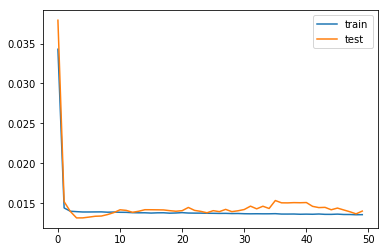

In [29]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Train on 35040 samples, validate on 8759 samples
Epoch 1/50
 - 4s - loss: 0.0409 - val_loss: 0.0561
Epoch 2/50
 - 2s - loss: 0.0152 - val_loss: 0.0212
Epoch 3/50
 - 2s - loss: 0.0140 - val_loss: 0.0150
Epoch 4/50
 - 2s - loss: 0.0140 - val_loss: 0.0137
Epoch 5/50
 - 2s - loss: 0.0139 - val_loss: 0.0134
Epoch 6/50
 - 1s - loss: 0.0139 - val_loss: 0.0131
Epoch 7/50
 - 1s - loss: 0.0139 - val_loss: 0.0132
Epoch 8/50
 - 2s - loss: 0.0139 - val_loss: 0.0130
Epoch 9/50
 - 3s - loss: 0.0139 - val_loss: 0.0130
Epoch 10/50
 - 2s - loss: 0.0138 - val_loss: 0.0132
Epoch 11/50
 - 2s - loss: 0.0139 - val_loss: 0.0131
Epoch 12/50
 - 1s - loss: 0.0138 - val_loss: 0.0132
Epoch 13/50
 - 1s - loss: 0.0138 - val_loss: 0.0133
Epoch 14/50
 - 1s - loss: 0.0138 - val_loss: 0.0132
Epoch 15/50
 - 1s - loss: 0.0138 - val_loss: 0.0133
Epoch 16/50
 - 1s - loss: 0.0138 - val_loss: 0.0134
Epoch 17/50
 - 1s - loss: 0.0138 - val_loss: 0.0134
Epoch 18/50
 - 1s - loss: 0.0138 - val_loss: 0.0132
Epoch 19/50
 - 1s - loss

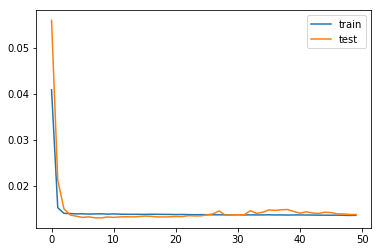

In [47]:
# design network
model = keras.models.Sequential()
model.add(keras.layers.LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(keras.layers.Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [48]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))


In [49]:

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 25.409
